<div style="background-color: #424449; padding: 30px; text-align: center; font-size: 36px; font-weight: bold;">
  <span style="color: #caccd1;">3.2 - Modelagem - XGBoost</span>
</div>

In [1]:
%%capture
%run 2.Pre_Processamento_ts.ipynb

Uma maneira de abordar um problema de séries temporais é transformá-lo em um problema de aprendizado supervisionado, que envolve prever uma variável de saída com base em um conjunto de variáveis de entrada conhecidas.

Para fazer isso, podemos criar janelas deslizantes nos dados históricos, onde cada janela representa uma amostra de treinamento. A variável de saída para cada amostra é o valor futuro que queremos prever, e as variáveis de entrada são os valores passados na janela.

Podemos então usar um algoritmo de aprendizado supervisionado, como o XGBoost, para treinar um modelo que preveja a variável de saída com base nas variáveis de entrada. O modelo será capaz de aprender padrões nos dados históricos e usá-los para fazer previsões precisas no futuro.

A biblioteca Sktime é ideal para lidar com este problema.

In [2]:
# Cópia do DataFrame original
df_xgb = df_raw.copy()

# Transformar a coluna data em formato datetime
df_xgb['data'] = pd.to_datetime(df_xgb['data'], format="%Y-%m-%d")

# Passar a coluna data como índice
df_xgb = df_xgb.set_index("data")

# Selecionar as linhas com índices após 1965
split_date = '1965-01-01'
df_xgb = df_xgb.loc[df_xgb.index >= split_date]

In [3]:
# Definindo a frequência para 'M' (Mensal)
freq = 'M'

# Convertendo pd.Timestamp para pd.Period
df_xgb = df_xgb.to_period(freq=freq)

**Validação Walk-Forward**

A validação walk-forward é uma técnica para avaliar o desempenho do modelo em dados não vistos. Ela consiste em dividir a série temporal em um conjunto de treinamento e um conjunto de teste e, em seguida, deslizar uma janela de tempo sobre o conjunto de teste para realizar previsões para um determinado período à frente. A cada iteração, o modelo é reajustado com o conjunto de treinamento atualizado e a previsão é realizada para o próximo período de teste. Isso permite avaliar o desempenho do modelo em dados não vistos, que é importante para séries temporais.

In [4]:
# Criar um objeto regressor XGBRegressor
regressor = XGBRegressor()

O código a seguir utiliza a biblioteca Sktime para implementar a Validação Walk-Forward e avaliar o desempenho do modelo utilizando diversas métricas de desempenho.

In [5]:
# Aplicação da Validação Walk-Forward
forecaster = make_reduction(regressor, strategy="recursive", window_length=24)

# Definir initial_window para garantir que haja dados suficientes no conjunto de treinamento inicial
initial_window = 36

fh = ForecastingHorizon(np.arange(1, 13))
# Definir o ExpandingWindowSplitter com o initial_window
cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window=initial_window)

# Lista para armazenar as métricas de desempenho

maes = []
mses = []
rmses = []
mapes = []
smapes = []

# Fazer a validação cruzada
for train, test in cv.split(df_xgb):
    # Separar os dados de treinamento e teste
    y_train_cv = df_xgb.iloc[train]
    y_test_cv = df_xgb.iloc[test]

    # Ajustar o modelo aos dados de treinamento
    forecaster.fit(y_train_cv)

    # Fazer as previsões para os dados de teste
    y_pred_cv = forecaster.predict(fh)

    # Calcular as métricas de desempenho para os dados de teste
    mae = metrics.mean_absolute_error(y_test_cv, y_pred_cv)
    mse = metrics.mean_squared_error(y_test_cv, y_pred_cv)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_cv, y_pred_cv))
    mape = mean_absolute_percentage_error(y_test_cv, y_pred_cv)
    
    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
    mapes.append(mape)


# Calcular a média das métricas de desempenho
print('MAE: ', np.mean(maes))
print('MSE: ', np.mean(mses))
print('RMSE: ', np.mean(rmses))
print('MAPE: ', np.mean(mapes)*100)

MAE:  2.8099249262954253
MSE:  13.043707868778753
RMSE:  3.439791782021331
MAPE:  3.6404134253006544


O código apresentado utiliza-se a função make_reduction para transformar um modelo de previsão de séries temporais em um modelo de aprendizado supervisionado. Essa função recebe como entrada um modelo de previsão de séries temporais e aplica uma estratégia para transformar as previsões de uma janela de tempo em uma única previsão. A estratégia foi a "recursive", que utiliza as previsões anteriores como entrada para a previsão atual. O window_length é o tamanho da janela de tempo utilizada para gerar as previsões anteriores, que serão usadas para treinar o modelo.

Para definir o horizonte de previsão, foi utilizado o objeto ForecastingHorizon, que define o número de períodos que o modelo deve prever. No código apresentado, o objeto é criado com o argumento np.arange(1, 13), que define um horizonte de 12 períodos à frente. Em seguida, esse objeto é passado como argumento para a função ExpandingWindowSplitter, que é responsável por dividir a série temporal em conjuntos de treinamento e teste e aplicar a validação cruzada.

O ExpandingWindowSplitter é uma classe que implementa um esquema de validação cruzada walk-forward. No código apresentado, a instância do ExpandingWindowSplitter é criada com um step_length de 12, que define quantos pontos avançar a janela de treinamento a cada iteração e um horizonte de previsão (fh) com um intervalo de 12 pontos. O initial_window é definido como 36, garantindo que haja dados suficientes no conjunto de treinamento inicial. O ExpandingWindowSplitter é então usado em um loop para dividir os dados em conjuntos de treinamento e teste em cada iteração, onde a janela de treinamento é incrementada a cada iteração. Em cada iteração, o modelo é ajustado aos dados de treinamento e usado para fazer previsões para o horizonte definido (fh). Ao final das iterações, a média das métricas de desempenho é calculada.

**Previsões**

In [6]:
# Separação em dados de treino e teste
y_train, y_test = temporal_train_test_split(df_xgb, test_size=12)

In [7]:
# Tamanho dos dados de treino e teste
print(y_train.shape, y_test.shape)

(684, 1) (12, 1)


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

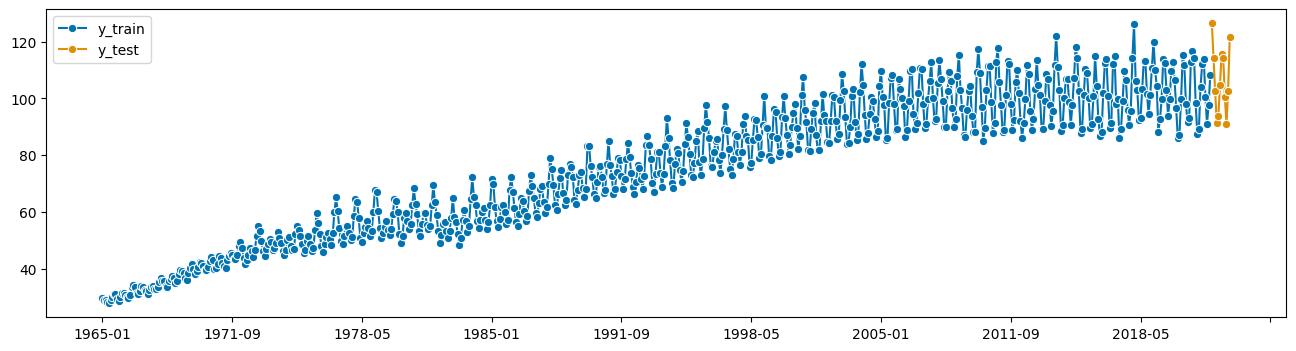

In [8]:
# Gráfico dos dados de treino e teste
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [9]:
# Especificar o período de tempo futuro para o qual as previsões devem ser geradas
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [10]:
# Criar um objeto regressor XGBRegressor
regressor = XGBRegressor()

In [11]:
# Gerar previsões com base no modelo XGBRegressor
forecaster = make_reduction(regressor, window_length=24, strategy="recursive")

O código cria um objeto forecaster que é utilizado para gerar previsões com base em um modelo de regressão. O método de previsão utilizado é o de redução, que utiliza um modelo de regressão passado como parâmetro (regressor) para fazer as previsões futuras.

A janela de previsão é definida com um tamanho de 24, o que significa que serão utilizadas as últimas 24 observações da série temporal para fazer a previsão do próximo período.

A estratégia utilizada é recursiva, o que significa que a previsão para cada período futuro é utilizada como entrada para prever o próximo período futuro. Essa estratégia pode ser útil em séries temporais com padrões sazonais ou com tendências de longo prazo.

In [12]:
# Ajusta o modelo aos dados de treinamento e realiza as previsões
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

In [13]:
# Valores preditos
y_pred

,producao
2022-01,118.307358
2022-02,108.765350
2022-03,96.092018
2022-04,86.860329
2022-05,90.321976
2022-06,99.404724
2022-07,112.010696
2022-08,112.422142
2022-09,92.671013
2022-10,90.406654


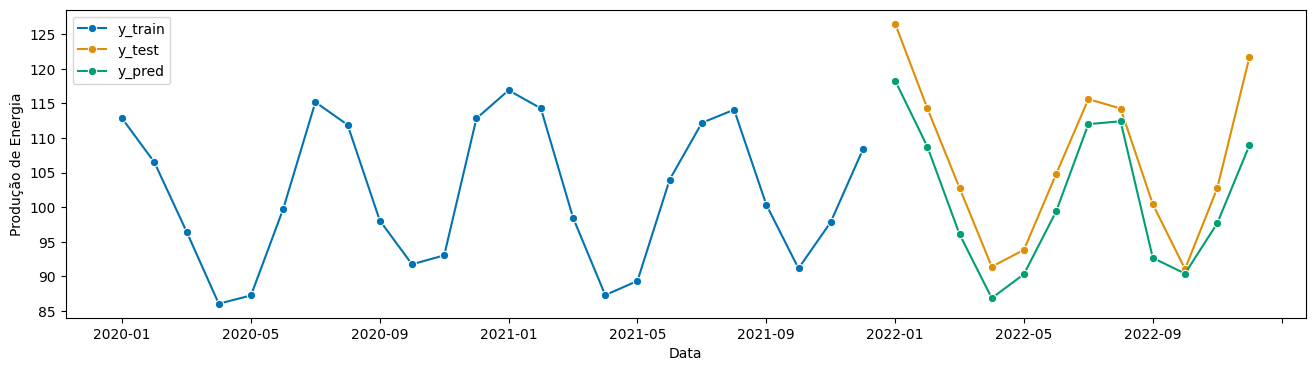

In [14]:
# Gráficos com os valores reais e valores previstos
plot_series(y_train['2020-01-01':], y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Data', y_label='Produção de Energia');

In [15]:
def smape(y_test, y_pred):
    numerator = np.abs(y_test - y_pred)
    denominator = np.abs(y_test) + np.abs(y_pred)
    return 200 * (numerator / denominator).mean()

In [16]:
# Modelo final

# Métricas
metricas = []

modelo = 'XGBoost'
MAE = metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
MAPE = mean_absolute_percentage_error(y_test, y_pred)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
SMAPE = smape(y_test, y_pred)

metricas.append((modelo, MAE, MSE, RMSE, MAPE*100, SMAPE[0]))

df_xgb = pd.DataFrame(metricas, columns=['Modelo', 'MAE', 'MSE', 'RMSE', 'MAPE', 'SMAPE'])

df_xgb

,Modelo,MAE,MSE,RMSE,MAPE,SMAPE
0,XGBoost,5.46678,39.19663,6.260721,5.026655,5.190921


**Otimização dos Hiperparâmetros**

In [17]:
# Encontrar os melhores parâmetros

validation_size = 12
cv = SlidingWindowSplitter(window_length=24, fh=validation_size, initial_window=60)


param_grid = {
    'estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'estimator__n_estimators': [100, 500, 1000]
}

regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = make_reduction(regressor, window_length=24, strategy="recursive")
frscv = ForecastingRandomizedSearchCV(forecaster, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42)

O código tem como objetivo encontrar os melhores parâmetros para um modelo de previsão de séries temporais usando o algoritmo XGBoost. Ele faz uso da classe ForecastingRandomizedSearchCV para realizar uma busca aleatória nos parâmetros definidos em "param_grid" e escolher a combinação que apresenta melhor desempenho de acordo com a validação cruzada realizada pelo SlidingWindowSplitter.

A primeira etapa é criar uma instância do SlidingWindowSplitter, que divide a série temporal em conjuntos de treinamento e teste usando uma janela deslizante. Neste caso, a janela de treinamento tem tamanho de 60 períodos e a janela de teste tem tamanho de 12 períodos. Isso significa que o modelo será treinado com 60 períodos e testado com 12 períodos em cada iteração.

Em seguida, é definido o grid de parâmetros que será testado na busca aleatória. Ele inclui valores para os parâmetros do algoritmo XGBoost, como a profundidade máxima da árvore, taxa de aprendizado, subamostragem de linhas e colunas e número de estimadores.

O XGBRegressor é então criado como estimador base, que será usado para treinar o modelo de previsão. A função make_reduction é utilizada para transformar o modelo de previsão em um modelo de aprendizado supervisionado, usando a estratégia "recursive" para gerar as previsões. Essa estratégia utiliza as previsões anteriores como entrada para a previsão atual.

Por fim, a instância do ForecastingRandomizedSearchCV é criada, utilizando o forecaster criado anteriormente como estimador, o SlidingWindowSplitter como validação cruzada e o grid de parâmetros definido. A busca aleatória será realizada por 100 iterações e o melhor conjunto de parâmetros será selecionado com base no desempenho médio do modelo durante a validação cruzada.

In [18]:
# Parâmetros
print(frscv)

ForecastingRandomizedSearchCV(cv=SlidingWindowSplitter(fh=12, initial_window=60,
                                                       window_length=24),
                              forecaster=RecursiveTabularRegressionForecaster(estimator=XGBRegressor(base_score=None,
                                                                                                     booster=None,
                                                                                                     callbacks=None,
                                                                                                     colsample_bylevel=None,
                                                                                                     colsample_bynode=None,
                                                                                                     colsample_bytree=None,
                                                                                                     early_stopping_rounds

In [19]:
%%time

# Ajusta o modelo aos dados de treinamento
frscv.fit(y_train)

CPU times: user 21min 32s, sys: 3.36 s, total: 21min 35s
Wall time: 14min 36s


ForecastingRandomizedSearchCV(cv=SlidingWindowSplitter(fh=12, initial_window=60,
                                                       window_length=24),
                              forecaster=RecursiveTabularRegressionForecaster(estimator=XGBRegressor(base_score=None,
                                                                                                     booster=None,
                                                                                                     callbacks=None,
                                                                                                     colsample_bylevel=None,
                                                                                                     colsample_bynode=None,
                                                                                                     colsample_bytree=None,
                                                                                                     early_stopping_rounds

In [20]:
# Resultados
frscv.cv_results_

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.018860,3.983708,0.043561,"{'estimator__subsample': 0.5, 'estimator__n_estimators': 1000, 'estimator__max_depth':...",44.0
1,0.016747,2.001682,0.043276,"{'estimator__subsample': 0.5, 'estimator__n_estimators': 500, 'estimator__max_depth': ...",29.0
2,0.031447,1.962506,0.042940,"{'estimator__subsample': 0.5, 'estimator__n_estimators': 500, 'estimator__max_depth': ...",81.0
3,0.017401,0.416379,0.041719,"{'estimator__subsample': 0.6, 'estimator__n_estimators': 100, 'estimator__max_depth': ...",36.0
4,0.043978,1.962974,0.041876,"{'estimator__subsample': 0.8999999999999999, 'estimator__n_estimators': 500, 'estimato...",92.0
5,0.015660,0.418294,0.041839,"{'estimator__subsample': 0.8999999999999999, 'estimator__n_estimators': 100, 'estimato...",26.0
6,0.043446,0.413984,0.041561,"{'estimator__subsample': 0.8999999999999999, 'estimator__n_estimators': 100, 'estimato...",90.0
7,0.009628,3.876296,0.042797,"{'estimator__subsample': 0.5, 'estimator__n_estimators': 1000, 'estimator__max_depth':...",10.0
8,0.018670,0.407605,0.042256,"{'estimator__subsample': 0.6, 'estimator__n_estimators': 100, 'estimator__max_depth': ...",43.0
9,0.024712,0.410549,0.042567,"{'estimator__subsample': 0.6, 'estimator__n_estimators': 100, 'estimator__max_depth': ...",67.0


In [21]:
# Índice dos melhores resultados
frscv.best_index_

93

In [22]:
# Melhores parâmetros
frscv.best_params_

{'estimator__subsample': 0.6,
 'estimator__n_estimators': 1000,
 'estimator__max_depth': 5,
 'estimator__learning_rate': 0.3,
 'estimator__colsample_bytree': 0.6,
 'estimator__colsample_bylevel': 0.4}

In [23]:
# Melhor Score
frscv.best_score_

0.0005215621848149907

**Modelo Final**

In [24]:
# Modelo final com os melhores parâmetros encontrados
regressor2 = XGBRegressor(subsample = 0.6,
n_estimators = 1000,
max_depth = 5,
learning_rate = 0.3,
colsample_bytree = 0.6,
colsample_bylevel = 0.4,
random_state = 42              )

In [25]:
# Gerar previsões com base no modelo XGBRegressor
forecaster = make_reduction(regressor2, window_length=24, strategy="recursive")

In [26]:
# Ajusta o modelo aos dados de treinamento
forecaster.fit(y_train)

# Obtendo as previsões com o modelo final
pred_xgb = forecaster.predict(fh)
pred_xgb

,producao
2022-01,117.222374
2022-02,110.849548
2022-03,99.008469
2022-04,86.436661
2022-05,90.406952
2022-06,103.102516
2022-07,114.078796
2022-08,106.810448
2022-09,97.701408
2022-10,91.593521


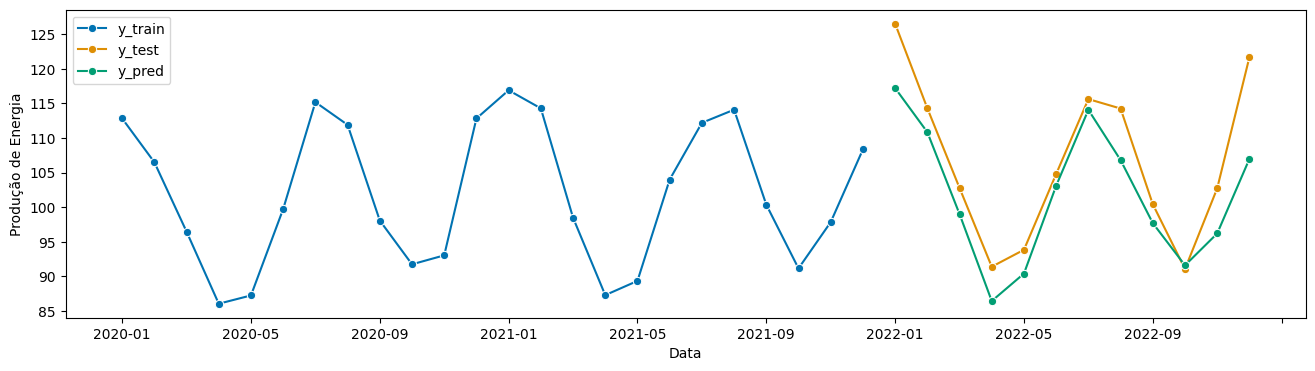

In [27]:
# Gráficos com os valores reais e valores previstos com o modelo final
plot_series(y_train['2020-01-01':], y_test, pred_xgb, labels=["y_train", "y_test", "y_pred"], x_label='Data', y_label='Produção de Energia');

In [28]:
# Avaliação Modelo final

# Métricas
metricas = []

modelo = 'XGBoost Final'
MAE = metrics.mean_absolute_error(y_test, pred_xgb)
MSE = metrics.mean_squared_error(y_test, pred_xgb)
MAPE = mean_absolute_percentage_error(y_test, pred_xgb)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, pred_xgb))
SMAPE = smape(y_test, pred_xgb)

metricas.append((modelo, MAE, MSE, RMSE, MAPE*100, SMAPE[0]))

df_xgb2 = pd.DataFrame(metricas, columns=['Modelo', 'MAE', 'MSE', 'RMSE', 'MAPE', 'SMAPE'])

df_xgb2

,Modelo,MAE,MSE,RMSE,MAPE,SMAPE
0,XGBoost Final,5.011554,39.716493,6.302102,4.531112,4.6877
